In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the data zip file from Google Drive
!cp /content/drive/MyDrive/EmotiScan/Data.zip .
!unzip -q -o Data.zip
!rm Data.zip

!cp /content/drive/MyDrive/EmotiScan/dataloader.py .

Mounted at /content/drive


In [1]:
# Import Libraries for Data Manipulation and Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import random
import cv2
import matplotlib.pyplot as plt
from pprint import pprint
import sys

# Import Libraries for Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Uncomment to install TensorFlow Addons
# !pip install --upgrade imbalanced-learn
# !pip install tensorflow-addons

# Import TensorFlow and Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from imblearn.over_sampling import SMOTE

# Import Keras Layers and Models
from keras import layers, Model
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Lambda, Dropout
from keras.utils import to_categorical
from keras.applications import DenseNet201, InceptionResNetV2

# Import Keras Optimizers, Metrics, and Callbacks
from keras.optimizers.legacy import Adam
from keras.metrics import AUC
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Add the Scripts directory to the Python path
sys.path.append('./Scripts/')

from dataloader import DataGenerator
from plotter import plot_metrics
from predictions import predict_emotion_and_facs

/Users/chris/miniconda3/envs/dev/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# Read the data and the image file paths
data = pd.read_csv("data_labels.csv")
image_paths = data['filepath'].tolist()

In [4]:
# Create emotion mappings
emotions_to_labels = {'negative': 0, 'positive': 1, 'surprise': 2}

# Apply mappings to the target
emotion_labels = data['high_level_emotion'].map(emotions_to_labels).values
facs_labels = data[['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']].values

In [5]:
# Get unique subject IDs
unique_subjects = data['subject'].unique()

# Split subjects into training and remaining (validation + test)
subjects_train, subjects_remain = train_test_split(unique_subjects, test_size=0.2, random_state=42)

# Split remaining subjects into validation and test
subjects_val, subjects_test = train_test_split(subjects_remain, test_size=0.45, random_state=42)

# Create splits based on selected subjects
train_set = data[data['subject'].isin(subjects_train)]
val_set = data[data['subject'].isin(subjects_val)]
test_set = data[data['subject'].isin(subjects_test)]

In [6]:
# Define data loader parameters
batch_size = 16
input_size = (224, 224)

# Extract features and labels
train_images = train_set['filepath'].tolist()
train_facs_features = train_set[['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']].values
train_emotion_labels = train_set['high_level_emotion'].map(emotions_to_labels).values

val_images = val_set['filepath'].tolist()
val_facs_features = val_set[['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']].values
val_emotion_labels = val_set['high_level_emotion'].map(emotions_to_labels).values

test_images = test_set['filepath'].tolist()
test_facs_features = test_set[['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']].values
test_emotion_labels = test_set['high_level_emotion'].map(emotions_to_labels).values

In [7]:
# Create custom data loader instances (Reference - dataloader.py)
train_data_loader = DataGenerator(train_images,
                                  train_facs_features,
                                  train_emotion_labels,
                                  batch_size,
                                  input_size,
                                  shuffle=True, Augment=True)

val_data_loader = DataGenerator(val_images,
                                val_facs_features,
                                val_emotion_labels,
                                batch_size,
                                input_size,
                                shuffle=True, Augment=False)

test_data_loader = DataGenerator(test_images,
                                 test_facs_features,
                                 test_emotion_labels,
                                 batch_size,
                                 input_size,
                                 shuffle=False, Augment=False)

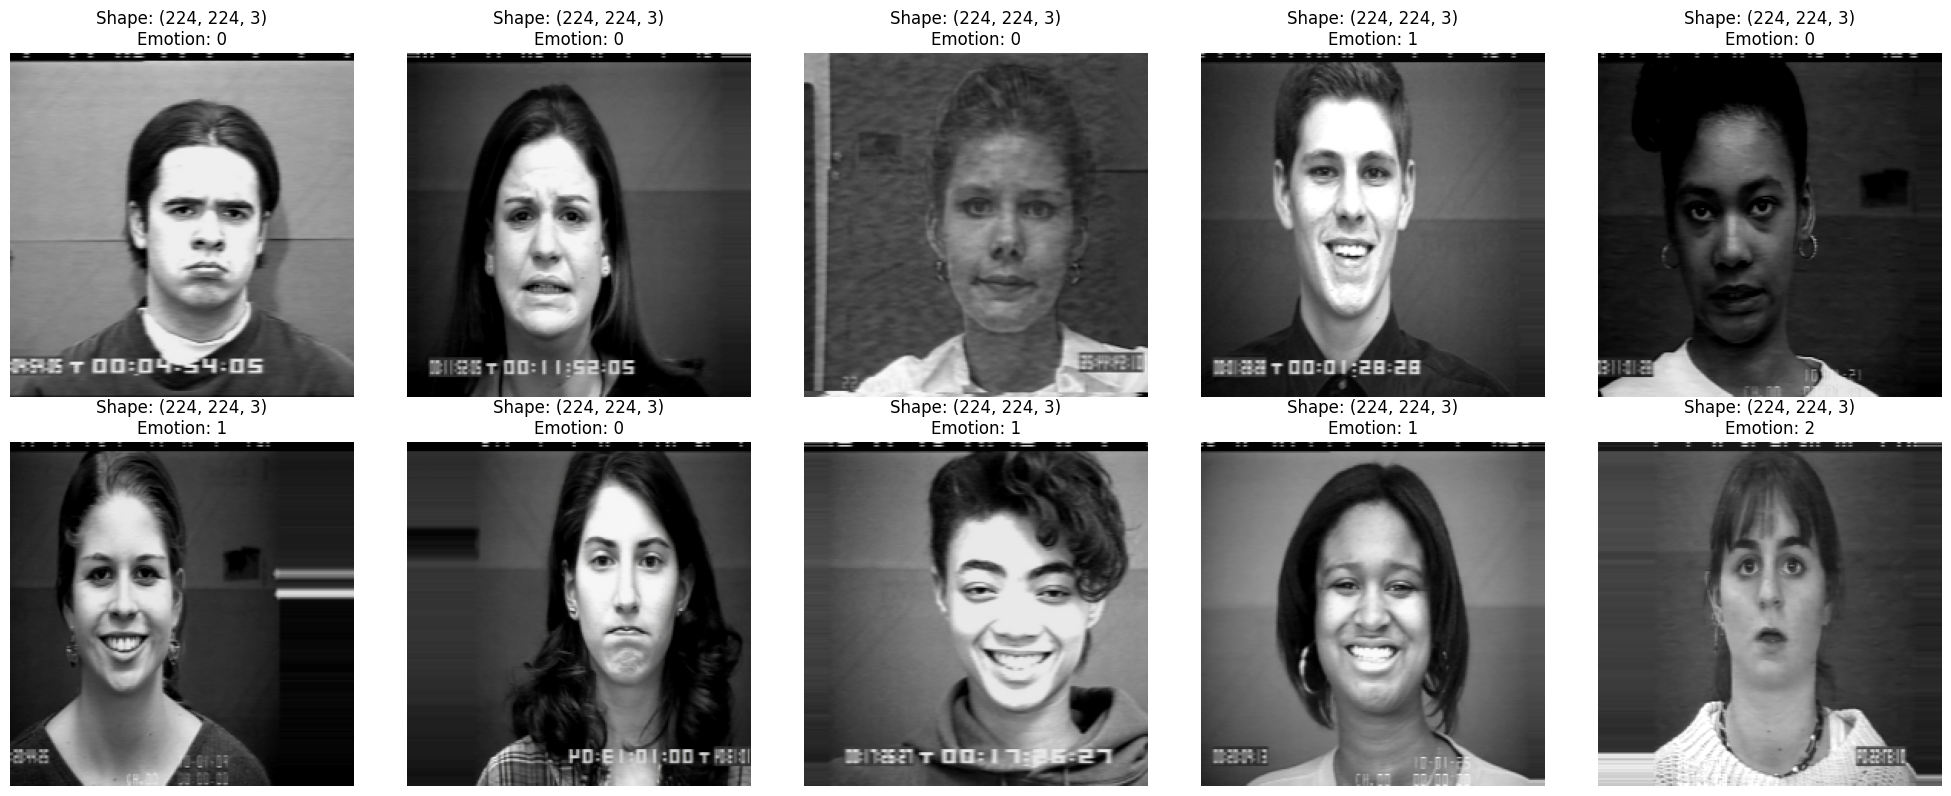

In [8]:
# Select 10 random sample indices to display
num_samples = 10
sample_indices = random.sample(range(len(train_images)), num_samples)

# Load and display sample images
plt.figure(figsize=(20, 8))
for i, idx in enumerate(sample_indices):
    image_path = train_images[idx]
    image = train_data_loader.load_and_preprocess_image(image_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Shape: {image.shape}\nEmotion: {train_emotion_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Class Weights

In [9]:
# Calculate class weights for emotion output using the oversampled data
emotion_class_weights = compute_class_weight('balanced', classes=np.unique(train_emotion_labels), y=train_emotion_labels)
emotion_class_weights = dict(enumerate(emotion_class_weights))

print("Emotion Class weights: \n")
pprint(emotion_class_weights)
print("=" * 75)

facs_class_weights = {}
facs_codes_list = ['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']

# Compute class weights for each FACS code using the oversampled data
for i, facs_code in enumerate(facs_codes_list):
    # Get class labels and counts for the FACS code
    classes = np.unique(train_facs_features[:, i])
    counts = np.bincount(train_facs_features[:, i].astype(int))

    # Compute class weights for the FACS code
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_facs_features[:, i])

    # Ensure the keys (classes) are strings
    facs_class_weights[facs_code] = {str(cls): weight for cls, weight in zip(classes, class_weights)}
print('\nFACS Class weights: \n')
pprint(facs_class_weights)


Emotion Class weights: 

{0: 0.5614702154626109, 1: 1.5543859649122806, 2: 1.7372549019607844}

FACS Class weights: 

{'AU1': {'0': 0.7334437086092715, '1': 1.570921985815603},
 'AU11': {'0': 0.537621359223301, '1': 7.145161290322581},
 'AU12': {'0': 0.6553254437869822, '1': 2.1095238095238096},
 'AU14': {'0': 0.535024154589372, '1': 7.637931034482759},
 'AU15': {'0': 0.6101928374655647, '1': 2.76875},
 'AU17': {'0': 0.7826855123674912, '1': 1.384375},
 'AU2': {'0': 0.6274787535410765, '1': 2.4611111111111112},
 'AU23': {'0': 0.5593434343434344, '1': 4.712765957446808},
 'AU24': {'0': 0.5579345088161209, '1': 4.815217391304348},
 'AU25': {'0': 1.0350467289719627, '1': 0.9672489082969432},
 'AU26': {'0': 0.5428921568627451, '1': 6.328571428571428},
 'AU27': {'0': 0.5798429319371727, '1': 3.6311475409836067},
 'AU4': {'0': 0.7637931034482759, '1': 1.4477124183006536},
 'AU6': {'0': 0.6420289855072464, '1': 2.260204081632653},
 'AU7': {'0': 0.6457725947521866, '1': 2.215}}


# **Building the Model**

As we progress to choosing a model that is best suited for this task, it is essential some key choices are made before the implementation this includes but not limited to learning rates, loss function, evaluation meteric, etc. For this task we will be using DenseNet as it has achieved competitive results on various benchmark datasets, including the ImageNet Large Scale Visual Recognition Challenge (ILSVRC).

Also multiple published research papers have used different variants of the VGG architecture as a baseline for facial image recognition.

## **Setting up**

In this task we have FACS code prediction along with Emotion prediction. Since a FAC code can be present or absent (0,1) we will be using the binary crossentropy loss and categorical crossentropy loss for emotion prediction as there are multiple classes (negative, positive, surprised). However, before we use these loss meterics it is important to remember that our data set is highly imbalanced as seen in the [Data Section](https://colab.research.google.com/drive/1f7plu_Pkqo7I9p-8eM2W-HTUD1tc2-Lr#scrollTo=Data) therefore these loss functions will need to be weighted.

The next step would be to choose an appropriate evaluation metric. In the case of emotion prediction it is a multiclass classification problem and given that the classes are imbalanced and no particular preference to either the type 1 or type 2 error, the chosen meteric is "Macro F1-Score".

The rationale behind choosing this metric is that the F1 macro score is commonly used in multi-class classification problems to evaluate the overall performance of the model across all classes. It calculates the F1 score for each class and then computes the average across classes. F1 macro considers precision and recall for each class, making it suitable for multi-class imbalanced datasets. It gives equal weight to all classes, preventing bias towards the majority class.

As for FACS code prediction the chosen metric is AUC PR (Area Under the Precision-Recall Curve). AUC PR is used in binary classification, particularly when dealing with imbalanced datasets. It focuses on the precision-recall trade-off, which is important when positive class samples are rare. AUC PR provides insights into the model's performance in capturing positive samples while maintaining a high precision. It's a better choice when positive class samples are much fewer than negative class samples.

# Model

In [34]:
# Creating a baseline model using DenseNet201 as a base
baseline_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freezing the layers in the pre-trained model
for layer in baseline_model.layers:
    layer.trainable = False

# Adding custom dense layers on top of the base model
x = baseline_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(158, activation='relu', kernel_regularizer=keras.regularizers.L2(0.02))(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01))(x)
x = Dropout(0.25)(x)
x = Dense(16, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01))(x)
x = Dropout(0.15)(x)

# Output layers for FACS codes and emotions
facs_output = Dense(15, activation='sigmoid', name='facs_output')(x)
emotion_output = Dense(3, activation='softmax', name='emotion_output')(x)

# Creating the final model
baseline_model = Model(inputs=baseline_model.input, outputs=[facs_output, emotion_output])

#==============================================================================#

# Compiling the model with specified optimizer, loss functions, and metrics
baseline_model.compile(optimizer=Adam(learning_rate=0.003),
                       loss={'facs_output': 'binary_crossentropy',
                             'emotion_output': 'categorical_crossentropy'},
                       loss_weights={'facs_output': facs_class_weights,
                                     'emotion_output': emotion_class_weights},
                       metrics={'facs_output': [AUC(curve='PR', name='auc')],
                                'emotion_output': tfa.metrics.F1Score(num_classes=3, average='macro', name='f1M')})

# Adding early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-8, restore_best_weights=True)

In [35]:
# Training the baseline model using the provided data loaders
baseline_history = baseline_model.fit(train_data_loader,
                                      validation_data=val_data_loader,
                                      epochs=80,
                                      callbacks=[reduce_lr, early_stopping])

Epoch 1/80
28/28 [==============================] - 52s 1s/step - loss: 6.0921 - facs_output_loss: 0.8330 - emotion_output_loss: 1.1001 - facs_output_auc: 0.1987 - emotion_output_f1M: 0.3307 - val_loss: 4.0127 - val_facs_output_loss: 0.6508 - val_emotion_output_loss: 1.0231 - val_facs_output_auc: 0.2016 - val_emotion_output_f1M: 0.2411 - lr: 0.0030
Epoch 2/80
28/28 [==============================] - 36s 1s/step - loss: 3.3231 - facs_output_loss: 0.6576 - emotion_output_loss: 0.9853 - facs_output_auc: 0.2305 - emotion_output_f1M: 0.2675 - val_loss: 2.7267 - val_facs_output_loss: 0.6417 - val_emotion_output_loss: 0.8973 - val_facs_output_auc: 0.3222 - val_emotion_output_f1M: 0.2411 - lr: 0.0030
Epoch 3/80
28/28 [==============================] - 34s 1s/step - loss: 2.5022 - facs_output_loss: 0.6027 - emotion_output_loss: 0.8857 - facs_output_auc: 0.2781 - emotion_output_f1M: 0.3789 - val_loss: 2.2012 - val_facs_output_loss: 0.5014 - val_emotion_output_loss: 0.8274 - val_facs_output_auc: 

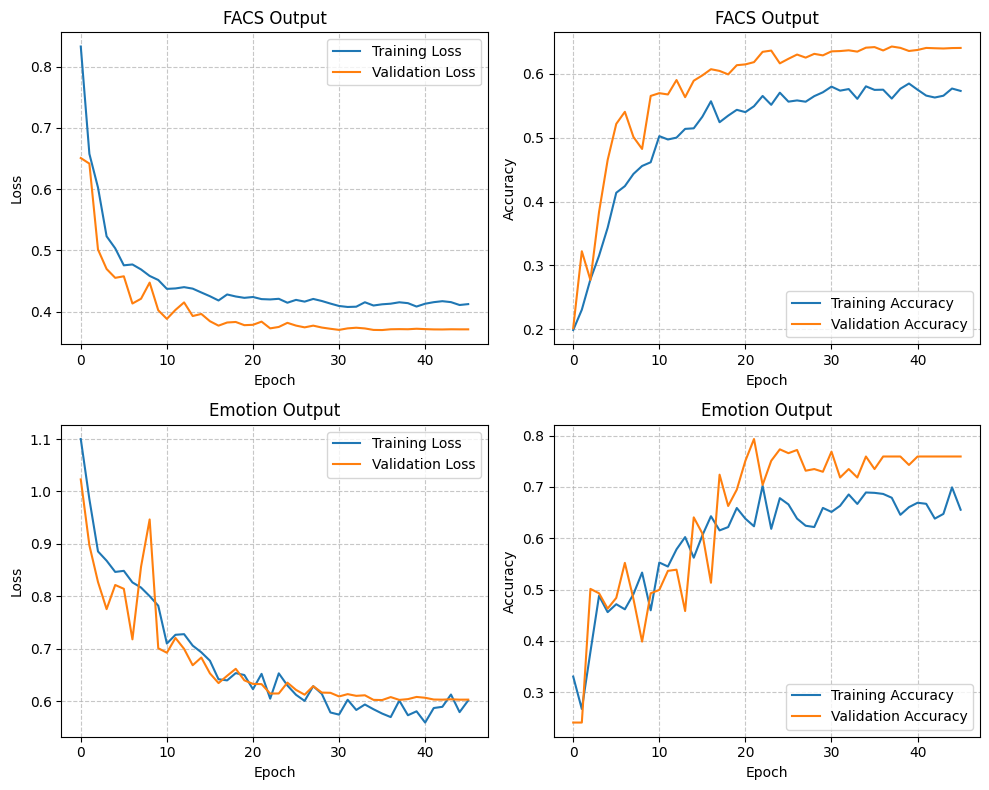

In [36]:
plot_metrics(baseline_history, facs_metric='facs_output_auc', emotion_metric='emotion_output_f1M')

In [37]:
test_loss = baseline_model.evaluate(test_data_loader, steps=len(test_data_loader))


print()
print("===" * 50)
print("\nTest Accuracy - FACS Codes:", round(test_loss[baseline_model.metrics_names.index('facs_output_auc')], 3))
print("Test Accuracy - Emotion Labels:", round(test_loss[baseline_model.metrics_names.index('emotion_output_f1M')], 3))

4/4 [==============================] - 1s 112ms/step - loss: 1.3485 - facs_output_loss: 0.3696 - emotion_output_loss: 0.5639 - facs_output_auc: 0.6749 - emotion_output_f1M: 0.8341


Test Accuracy - FACS Codes: 0.675
Test Accuracy - Emotion Labels: 0.834


In [ ]:
# Save model
# baseline_model.save("emotiscan_model.h5")

In [39]:
facs_predictions, emotion_predictions = baseline_model.predict(test_data_loader)

# Defining Threshold for array of probabilities
threshold = 0.5

facs_predictions = (facs_predictions > threshold).astype(int)
emotion_predictions = (emotion_predictions > threshold).astype(int)

# Emotion class labels
class_labels_emotion = ['negative', 'happy', 'surprised']

# FACS Codes class labels
class_labels_facs = ['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']

predicted_labels_emotion_classes = np.argmax(emotion_predictions, axis=1)

# True labels and Predicted labels for emotion and FACS codes
true_labels_emotion =  test_emotion_labels
predicted_labels_emotion =  predicted_labels_emotion_classes

true_labels_facs =  test_facs_features
predicted_labels_facs =  facs_predictions

# # Classification Report for Emotion
print("Classification Report - Emotion:")
print(classification_report(true_labels_emotion, predicted_labels_emotion, target_names=class_labels_emotion, zero_division=1))

print('==' * 30)

# Classification Report for FACS Codes
print("\nClassification Report - FACS Codes:")
print(classification_report(true_labels_facs, predicted_labels_facs, zero_division=1, target_names=class_labels_facs))

4/4 [==============================] - 4s 124ms/step
Classification Report - Emotion:
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87        31
       happy       0.90      0.82      0.86        11
   surprised       0.75      0.80      0.77        15

    accuracy                           0.84        57
   macro avg       0.84      0.83      0.83        57
weighted avg       0.84      0.84      0.84        57


Classification Report - FACS Codes:
              precision    recall  f1-score   support

        AU17       1.00      0.06      0.11        18
         AU1       0.65      0.58      0.61        19
         AU2       0.73      0.69      0.71        16
        AU25       0.87      0.79      0.83        34
        AU27       0.69      0.82      0.75        11
         AU4       1.00      0.00      0.00        22
         AU7       1.00      0.00      0.00        11
        AU23       1.00      0.00      0.00         7
        A

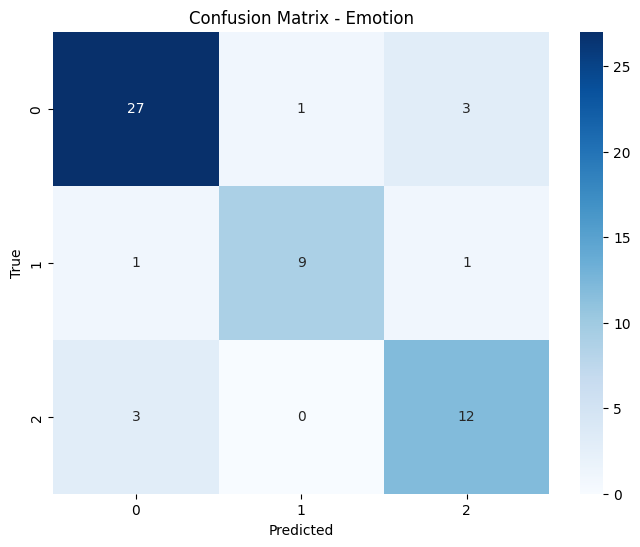

In [40]:
# Confusion Matrix for Emotion
emotion_conf_matrix = confusion_matrix(true_labels_emotion, predicted_labels_emotion)
plt.figure(figsize=(8, 6))
sns.heatmap(emotion_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Emotion')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

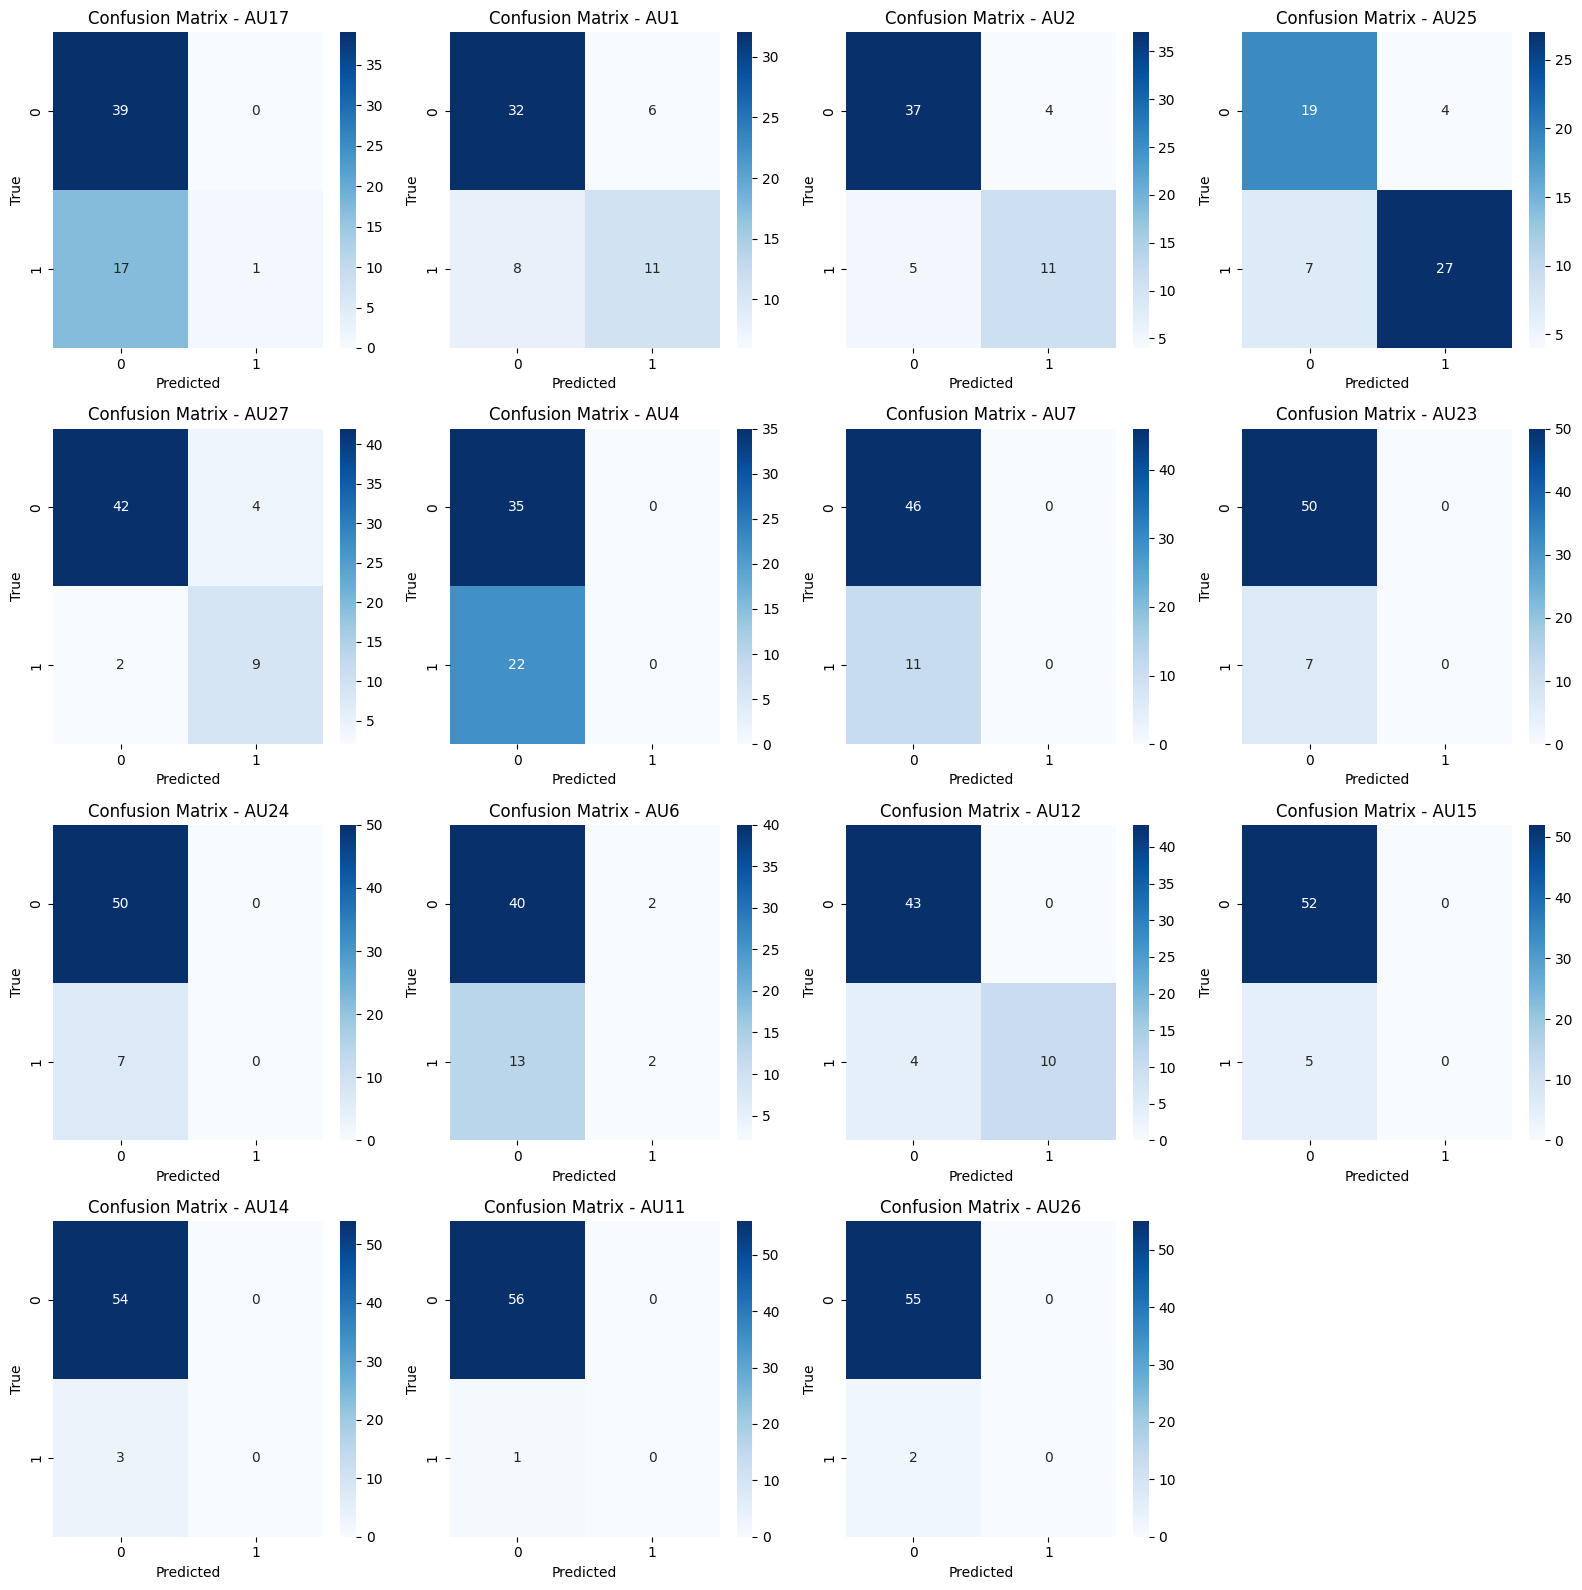

In [41]:
# Confusion Matrix for FACS Codes
true_labels_facs = test_facs_features
predicted_labels_facs = facs_predictions

num_facs_codes = true_labels_facs.shape[1]

# Calculate the number of rows needed based on 4 columns
num_rows = int(np.ceil(num_facs_codes / 4))

# Create subplots for each FACS code
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, 4*num_rows))

# Flatten the 2D array of subplots into a 1D array for easy indexing
axes = axes.flatten()

class_labels_facs = ['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']

for i in range(num_facs_codes):
    facs_conf_matrix = confusion_matrix(true_labels_facs[:, i], predicted_labels_facs[:, i])
    sns.heatmap(facs_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {class_labels_facs[i]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

# Remove any empty subplots
for j in range(num_facs_codes, num_rows*4):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [2]:
# Example usage
img_path = "./cohn-kanade-images/S026/001/S026_001_00000015.png"
predicted_emotion, predicted_facs = predict_emotion_and_facs(img_path)

print("Predicted Emotion:", predicted_emotion)
print("Predicted FACS Codes:", predicted_facs)

1/1 [==============================] - 3s 3s/step
Predicted Emotion: surprised
Predicted FACS Codes: ['AU1', 'AU2', 'AU25', 'AU27']
